In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import sys
import os

import iceutils as ice
import jax.numpy as jnp
import jax
  
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, HMC, Predictive

import arviz as az

In [2]:
N_dim = 4

def rosenb_potential(x):
    
    # Constants
    a = 1.0
    b = 5.0
    
    # Compute multi-dimensional Rosenbrock function
    f = 0.0
    for i in range(1, N_dim):
        df = b * (x[i] - x[i-1]**2)**2 + (a - x[i-1])**2
        f += df
    return f

In [3]:
def run_inference(potential, rng_key):
    
    # Run inference
    kernel = NUTS(potential_fn=potential, dense_mass=True)
    num_samples = 10000
    mcmc = MCMC(kernel, num_warmup=2000, num_samples=num_samples)
    mcmc.run(rng_key, init_params=jnp.zeros(N_dim))
    
    # Return samples
    return mcmc.get_samples()

In [4]:
# Initialize RNG
rng_key = jax.random.PRNGKey(11)

# Run inference
samples = run_inference(rosenb_potential, rng_key)

sample: 100%|██████| 12000/12000 [00:06<00:00, 1756.07it/s, 5 steps of size 3.10e-01. acc. prob=0.92]


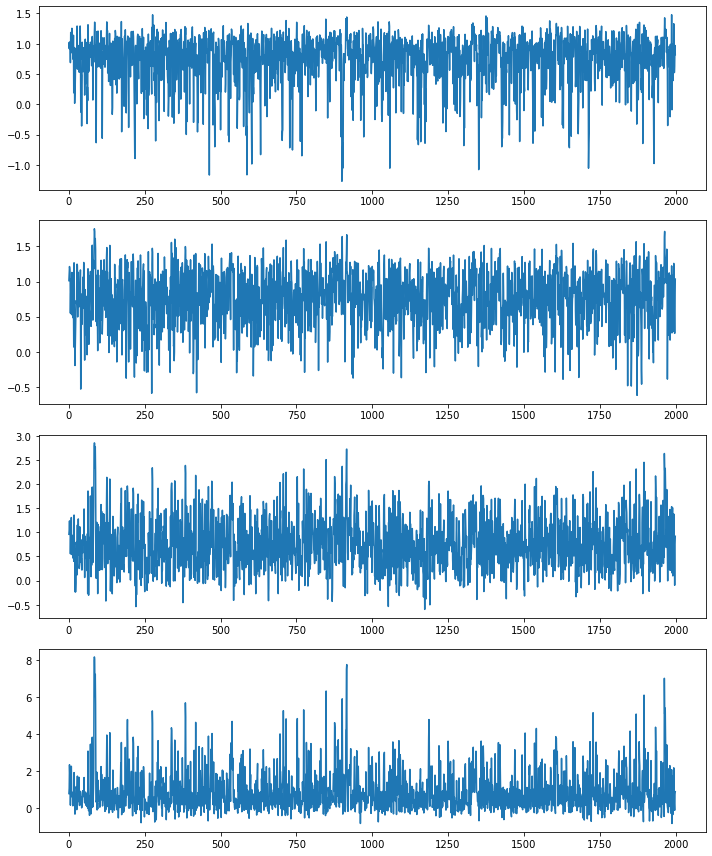

In [5]:
fig, axes = plt.subplots(nrows=N_dim, figsize=(10, 12))

sub = 5
for i in range(N_dim):
    axes[i].plot(samples[::sub, i])
    
with h5py.File('samples_mcmc.h5', 'w') as fid:
    fid['samples'] = samples[::sub]
    
plt.tight_layout()

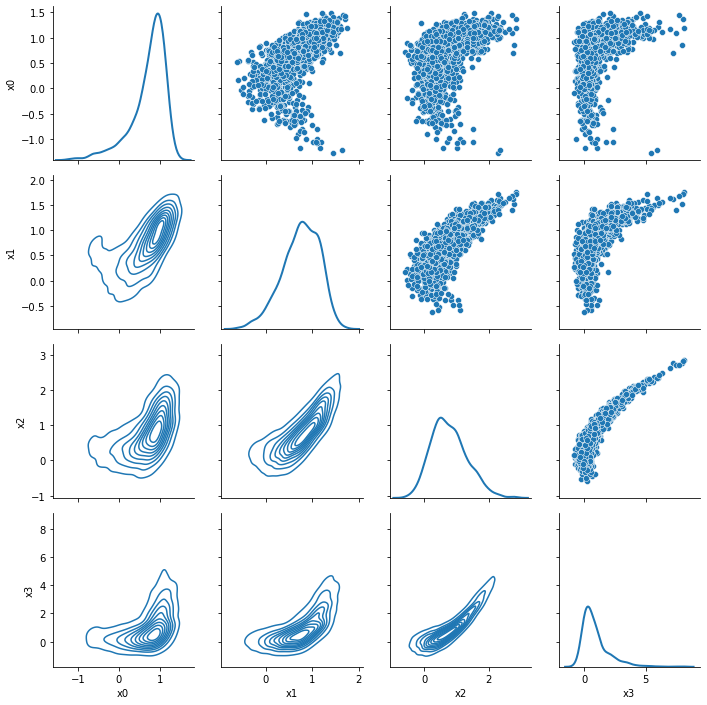

In [7]:
import seaborn as sns
import pandas as pd

df_data = {}
for i in range(samples.shape[1]):
    df_data['x%d' % i] = samples[::sub, i]
df = pd.DataFrame(df_data)

g = sns.PairGrid(df, height=2.5)
g.map_diag(sns.kdeplot, lw=2, legend=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
